# Описание проекта

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy import stats as st

In [2]:
# прочитаем данные
geo0 = pd.read_csv('/datasets/geo_data_0.csv')
geo1 = pd.read_csv('/datasets/geo_data_1.csv')
geo2 = pd.read_csv('/datasets/geo_data_2.csv')
# предполагая, что датасеты аналогичны, проведем предобработку на примере geo0
geo0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет, форматы корректные.

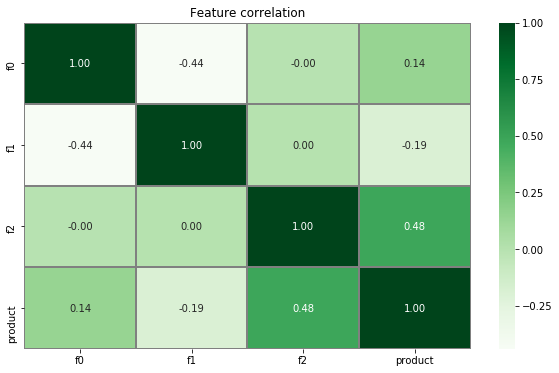

In [4]:
numeric = ['f0', 'f1', 'f2', 'product']
cm = geo0[numeric].corr()
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="Greens")
ax.set_title('Feature correlation')
plt.show()

Слишком большой мультиколлинеарности нет.

# 2. Обучение и проверка модели

Для каждого региона обучим свою модель, предскажем объем запасов на валидационной выборке

In [5]:
predict_list = []
target_list = []
counter = 0
# для каждого региона обучим свою модель
regions = [geo0, geo1, geo2]
for i in regions:

    X = i[numeric].drop('product', axis=1)
    y = i['product']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=1)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # предскажем объем запасов на валидационной выборке
    predictions = model.predict(X_valid)
    
    # посчитаем средний запас предсказанного сырья по региону
    
    mean_stock = predictions.mean()
    
    # подсчитаем RMSE модели
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    
    # сохраним три списка предсказаний и три списка фактических значений в отдельные списки 
    predict_list.append(predictions)
    target_list.append(y_valid)
    
    print('Для региона', counter, 'средние предсказанные запасы - ', mean_stock, ', RMSE - ', rmse)
    counter += 1

Для региона 0 средние предсказанные запасы -  92.49262459838863 , RMSE -  37.74258669996437
Для региона 1 средние предсказанные запасы -  69.12040524285558 , RMSE -  0.8943375629130564
Для региона 2 средние предсказанные запасы -  94.9568304858529 , RMSE -  39.86671127773423


#### Вывод

Видим, что в регионе № 1 запасы заметно меньше, чем в двух других, однако показатель RMSE модели заметно лучше.

# 3. Подготовка к расчёту прибыли

In [6]:
# зададим бюджет на разведку
budget = 10000000000 
# зададим количество скважин
amount = 200
# зададим прибыль от тысячи баррелей
profit_per_1k = 450000
# подсчитаем минимальный средний запас нефти на скважине для безубыточной работы
stock_margin = budget / (profit_per_1k*amount)
print(stock_margin)

111.11111111111111


#### Вывод

Как видим, минимальный средний запас нефти заметно выше, чем средний по всем 3 регионам, так что нам обязательно нужно найти самые лучшие скважины.

# 4. Расчёт прибыли и рисков 

In [7]:
state = np.random.RandomState(12345)

Зададим функцию, которая будет подсчитывать прибыль от 200 скважин с лучшими предсказаниями.

In [8]:
def profit_calculator(target, predicts):
    predicts_sorted = predicts.sort_values(ascending=False)
    selected = target[predicts_sorted.index][:amount]
    return profit_per_1k * selected.sum() - budget

Для каждого региона выберем 1000 раз по 500 скважин, для которых найдем прибыль от 200 лучших.
Подсчитаем также доверительный интервал и вероятность убытков.

In [9]:
for i in [0, 1, 2]:   
    values = []
    for j in range(1000):
        target_subsample = target_list[i].reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        predict_subsample = pd.Series(predict_list[i])[target_subsample.index]
        
        values.append(profit_calculator(target_subsample, predict_subsample))

    values = pd.Series(values)
    mean_profit = values.mean()

    #confidence_interval = st.t.interval(0.95, len(values)-1, mean_profit, values.sem())
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    
    print('Средняя прибыль ', mean_profit)
    print('Доверительный интервал ', confidence_interval)
    
    loss = values[values<0]
    loss_prob = len(loss)/len(values)
    
    print('Вероятность убытков {:.2%}'.format(loss_prob))
    print()

Средняя прибыль  458100401.7997511
Доверительный интервал  (-91938453.32589054, 1015824888.6825125)
Вероятность убытков 4.60%

Средняя прибыль  533056709.60397387
Доверительный интервал  (99430448.401124, 973064424.8886513)
Вероятность убытков 0.60%

Средняя прибыль  411076672.55868226
Доверительный интервал  (-138944979.6146276, 959378918.3216925)
Вероятность убытков 7.20%



#### Вывод

Как мы видим, несмотря на то, что в регионе № 1 средний предсказанный запас нефти был заметно меньше, чем в 0 и 2, разработку следует проводить именно в нём, так как только в этом регионе вероятность убытков ниже целевого уровня в 2,5%.

### Общие выводы

В ходе работы над проектом мы:

- предсказали при помощи линейной регрессии запасы нефти в 3 регионах, а также соответствующие средние показатели и RMSE
- с помощью бутстрепа из 1000 выборок по 500 скважин расчитали среднюю прибыль для 200 лучших месторождений каждого региона
- оценили 95 %-ый доверительный интервал прибыли
- оценили вероятность убытков в каждом регионе
- пришли к выводу, что разработку следует вести в регионе № 1, так как только в нём вероятность убытка при разработке 200 лучших скважин из 500 случайных меньше 2,5 %.